In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

from algos import *
from infect import infect
from sbm import SBM

In [2]:
def create_communities(s, N, M):
    size = round(N/M)
    communities = []

    for i in range(M):
        if(i == M-1):
            comm = s[i*size:]
        else:
            comm = s[i*size:(i+1)*(size)]
        communities.append(comm)

    return communities

In [3]:
def iter(N,M,q0,q1,p0,p1,time_steps,num_sims,method,dataset='sbm'):

    name = dataset+'N'+str(N)+'_M'+str(M)+'_SIM'+str(num_sims)+'_step'+str(time_steps)+'_q0'+str(q0)+'_q1'+str(q1)+'_p0'+str(p0)+'_p1'+str(p1)+method+'graphs.pkl'
    if not os.path.isfile(name):
        print('Generating synthetic dataset!')
        Gs = np.zeros((num_sims,N,N))
        Communities = dict()
        data = dict()
        Individuals = dict()
        if dataset=='sbm':
            for i in range(num_sims):
                Gs[i] = SBM(N,M,q0,q1)
                Individuals[i] = infect(Gs[i],p0,p1,time_steps)
                s = Individuals[i]
                Communities[i] = create_communities(s, N,M)
        elif dataset=='iid':
            for i in range(num_sims):
                individuals = np.random.choice([0, 1], size=N, p=[1 - p0, p0])
                Individuals[i] = individuals
                s = Individuals[i]
                Communities[i] = create_communities(s, N,M)
        data['graph'] = Gs
        data['communities'] = Communities
        data['individuals'] = Individuals
        with open(name, 'wb') as infile:
            pickle.dump(data,infile) 


    ###################################################
    '''your code for initialization parameters if needed''' 
    fraction_ppl = 0
    fraction_family = 0
    fraction_ppl_in_family = 0
    num_tests = 0
    num_stages = 0

    ###################################################
        
    if os.path.isfile(name):
        with open(name, 'rb') as infile:
            data = pickle.load(infile) 
        #print('Data loaded!')
    for i in range(num_sims): 
        '''
        if dataset=='synthetic':
            G = data['graph'][i]
            communities = data['communities'][i]
            individuals = data['individuals'][i]
        '''
        ###################################################
        '''your code to calculate the statistics here'''
        communities = data['communities'][i]
        individuals = data['individuals'][i] 

        if(method == "binary"):
            '''
            If dataset = iid
                Then the 'individuals' will be laid out in a randomized way
            If the dataset = sbm
                The 'individuals' are organized such that they are next to members of their community
                B/c within 'infect', the rows of G are organized in such a fashion
            '''
            s = individuals.copy()
            if dataset == 'sbm':
                np.random.shuffle(s)

            numtests_bs, num_stages_bs, _ = binary_splitting(s)
            num_tests += numtests_bs
            num_stages += num_stages_bs
        elif(method == "Q1"):   # iid
            numtests_q1, num_stages_q1 = Qtesting1(individuals)
            num_tests += numtests_q1
            num_stages += num_stages_q1
        elif(method == "Q2"):   # iid
            numtests_q2, num_stages_q2 = Qtesting2(individuals)
            num_tests += numtests_q2
            num_stages += num_stages_q2
        elif(method == "diag"):
            s = individuals.copy()
            if dataset == 'sbm':
                np.random.shuffle(s)
            
            numtests_diag, num_stages_diag = diag_splitting(s)
            num_tests += numtests_diag
            num_stages += num_stages_diag
        elif(method == "comm1"):    # sbm
            numtests_comm1, num_stages_comm1 = Q1_commaware(communities)
            num_tests += numtests_comm1
            num_stages += num_stages_comm1
        elif(method == "comm2"):    # sbm
            numtests_comm2, num_stages_comm2 = Q2_commaware(communities)
            num_tests += numtests_comm2
            num_stages += num_stages_comm2


    ###################################################
    '''your code to calculate the statistics here''' 
    '''Do not forget to take the average'''
    num_tests /= num_sims
    num_stages /= num_sims
    ###################################################
            

    return fraction_ppl, fraction_family, fraction_ppl_in_family, num_tests, num_stages
        

<div class="alert alert-warning">
<b>Task 1 </b> 
Plot how the fraction of infected people, the percentage of infected communities, and the average percentage of infected people in each community change with the each setting for the synthetic dataset described in the following table and comment on the results. Average over at least $100$ SBM network realization.     

</div>

| N | M | q0, q1 | p0 | p1 |time steps  |
|---|---|--------|----|----|------------|
|256| 16| (1,0)  |0.001|[0.05:1]|2|
|   | 16|(0.9, 0.1)  | 0.001| [0.05:1]|2     |
|   | 16 |(0.5, 0.2)  | 0.001| [0.05:1]|2     |

In [152]:
# def Q1_round(s, max_stages):
#     inf_people = num_infected(s)
#     n = round(len(s)/10)

#     if(inf_people == 0 or len(s)<=1):    # Only one test + one stage b/c don't need to go any further
#         return 1,1
#     elif(n <= 1 or (inf_people <= n and inf_people >=1)):
#         diag_tests, diag_stages = diag_splitting(s)
#         return 1 + diag_tests, 1 + diag_stages
#     else:   # run a recursive version of HGBSA
#         num_per_group = round(len(s)/inf_people)
        
#         # for each subgroup, call function again
#         tests = 1 # = this testing group
#         for i in range(int(inf_people)):
#             stages = 1
#             if(i == inf_people-1):
#                 subGroup = s[i*num_per_group:]
#             else:
#                 subGroup = s[i*num_per_group:(i+1)*(num_per_group)]
            
#             t, st = Q1_round(subGroup, max_stages)
#             stages += st
#             tests += t   # number of tests in subtree

#             max_stages = max(max_stages, stages)
#         return tests, max_stages

# def Qtesting1(s):
#     '''
#     s(np.array): binary string of infection status
#     '''
#     num_tests = 0
#     stages = 0
#     ###################################################
#     '''your code here'''
#     #print("RUNNING TEST ON original: ", s, "\n")
#     #num_tests, stages = hgbsa(s)
#     num_tests, stages = Q1_round(s, stages)
#     #print("Total tests: ", num_tests, "\tTotal stages: ", stages)

#     ###################################################

#     return num_tests, stages

In [10]:
# def Q2_round(s, max_stages):
#     real_inf_people = num_infected(s)
#     n = round(len(s)/10)
#     inf_est = 0

#     # Imitation of the range testing capabilities
#     if (real_inf_people == 0):
#         inf_est = 0
#     elif(real_inf_people == 1):
#         inf_est = 1
#     elif(real_inf_people == 2 or real_inf_people == 3):
#         inf_est = 2
#     elif(real_inf_people < 8):
#         inf_est = 4
#     else:
#         inf_est = max(8, round(len(s)/7))
    

#     if (inf_est == 0 or len(s) <= 1): # If negative test or only one person in test
#         return 1,1
#     elif(n <= 1 or (inf_est <= n )): # if 10 or less people, or k is below threshold
#         diag_tests, diag_stages = diag_splitting(s)
#         return 1+diag_tests, 1+diag_stages
#     else:   # run a recursive version of HGBSA
#         num_per_group = round(len(s)/inf_est)
        
#         # for each subgroup, call function again
#         tests = 1 # = this testing group
#         for i in range((inf_est)):
#             stages = 1
#             if(i == inf_est-1):
#                 subGroup = s[i*num_per_group:]
#             else:
#                 subGroup = s[i*num_per_group:(i+1)*(num_per_group)]
            
#             t, st = Q2_round(subGroup, max_stages)
#             stages += st
#             tests += t   # number of tests in subtree

#             max_stages = max(max_stages, stages)
#         print("TOTAL TESTS: ", tests, "\n")
#         return tests, max_stages
  
# def Qtesting2(s):
#     '''
#     s(np.array): binary string of infection status
#     '''
#     num_tests = 0
#     stages = 0
#     ###################################################
#     '''your code here'''
#     num_tests, stages = Q2_round(s, stages)
#     #num_tests, stages = hgbsa(s)

#     ###################################################
#     return num_tests, stages

In [154]:
# def Q1_commaware(communities):
#     tests = 0
#     max_stages = 0
#     for cult in communities:
#         #print("Running tests on ", cult)
#         t, st = Qtesting1(cult)
#         tests += t
#         max_stages = max(st, max_stages)
#     return tests, max_stages+1

# def Q2_commaware(communities):
#     tests = 0
#     max_stages = 0
#     for cult in communities:
#         #print("Running tests on ", cult)
#         t, st = Qtesting2(cult)
#         tests += t
#         max_stages = max(st, max_stages)
#     return tests, max_stages+1

In [ ]:
# N = 100
# M = 10
# q0 = 0.1
# q1 = 0.01
# p1 = 0.05
# time_steps = 2
# num_sims = 40
# binary = 'binary'
# diag = 'Q1'
# testing1 = 'Q2'
# testing2 = 'diag'

# method5 = 'comm1'
# method6 = 'comm2'

# p_values = np.linspace(0.01, 1.0, 10)
# plot_results(N, M, q0, q1, p1, time_steps, num_sims, binary, diag,testing1, testing2, method5, method6, p_values)

In [4]:
def plot_iid(N, M, q0, q1, p1, time_steps, num_sims, binary, diag, testing1, testing2, p_values):
    num_tests_binary_iid = []
    num_stages_binary_iid = []

    num_tests_diag_iid = []
    num_stages_diag_iid = []

    num_tests_q1 = []
    num_stages_q1 = []  

    num_tests_q2 = []
    num_stages_q2 = []

    # Binary
    for p0 in p_values:
        _, _, _, num_tests, num_stages = iter(N, M, q0, q1, p0, p1, time_steps, num_sims, binary, dataset='iid')
        num_tests_binary_iid.append(num_tests)
        num_stages_binary_iid.append(num_stages)

    # Diagonal
    for p0 in p_values:
        _, _, _, num_tests, num_stages = iter(N, M, q0, q1, p0, p1, time_steps, num_sims, diag, dataset='iid')
        num_tests_diag_iid.append(num_tests)
        num_stages_diag_iid.append(num_stages)

    # Q1
    for p0 in p_values:
        _, _, _, num_tests, num_stages = iter(N, M, q0, q1, p0, p1, time_steps, num_sims, testing1, dataset='iid')
        num_tests_q1.append(num_tests)
        num_stages_q1.append(num_stages)     

    # Q2
    for p0 in p_values:
        _, _, _, num_tests, num_stages = iter(N, M, q0, q1, p0, p1, time_steps, num_sims, testing2, dataset='iid')
        num_tests_q2.append(num_tests)
        num_stages_q2.append(num_stages) 


    plt.figure(figsize=(18, 8))
    
    # Plot for number of tests
    plt.subplot(1, 2, 1)
    plt.plot(p_values, num_tests_binary_iid, marker='o', label=binary)
    plt.plot(p_values, num_tests_diag_iid, marker='x', label=diag)
    plt.plot(p_values, num_tests_q1, marker='^', label=testing1)
    plt.plot(p_values, num_tests_q2, marker='^', label=testing2)

    plt.title('Number of Tests vs p0')
    plt.xlabel('p0')
    plt.ylabel('Number of Tests')
    plt.legend()
    
    # Plot for number of stages
    plt.subplot(1, 2, 2)
    plt.plot(p_values, num_stages_binary_iid, marker='o', label=binary)
    plt.plot(p_values, num_stages_diag_iid, marker='x', label=diag)
    plt.plot(p_values, num_stages_q1, marker='^', label=testing1)
    plt.plot(p_values, num_stages_q2, marker='^', label=testing2)

    plt.title('Number of Stages vs p0')
    plt.xlabel('p0')
    plt.ylabel('Number of Stages')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

TOTAL TESTS:  63 

TOTAL TESTS:  84 

TOTAL TESTS:  70 

TOTAL TESTS:  69 

TOTAL TESTS:  74 

TOTAL TESTS:  63 

TOTAL TESTS:  65 

TOTAL TESTS:  73 

TOTAL TESTS:  82 

TOTAL TESTS:  61 

TOTAL TESTS:  65 

TOTAL TESTS:  64 

TOTAL TESTS:  74 

TOTAL TESTS:  70 

TOTAL TESTS:  64 

TOTAL TESTS:  73 

TOTAL TESTS:  65 

TOTAL TESTS:  69 

TOTAL TESTS:  68 

TOTAL TESTS:  78 

TOTAL TESTS:  75 

TOTAL TESTS:  67 

TOTAL TESTS:  71 

TOTAL TESTS:  78 

TOTAL TESTS:  68 

TOTAL TESTS:  74 

TOTAL TESTS:  58 

TOTAL TESTS:  73 

TOTAL TESTS:  61 

TOTAL TESTS:  75 

TOTAL TESTS:  66 

TOTAL TESTS:  71 

TOTAL TESTS:  66 

TOTAL TESTS:  63 

TOTAL TESTS:  71 

TOTAL TESTS:  73 

TOTAL TESTS:  71 

TOTAL TESTS:  73 

TOTAL TESTS:  71 

TOTAL TESTS:  73 

TOTAL TESTS:  96 

TOTAL TESTS:  66 

TOTAL TESTS:  71 

TOTAL TESTS:  81 

TOTAL TESTS:  68 

TOTAL TESTS:  78 

TOTAL TESTS:  76 

TOTAL TESTS:  62 

TOTAL TESTS:  66 

TOTAL TESTS:  90 

TOTAL TESTS:  81 

TOTAL TESTS:  79 

TOTAL TESTS:

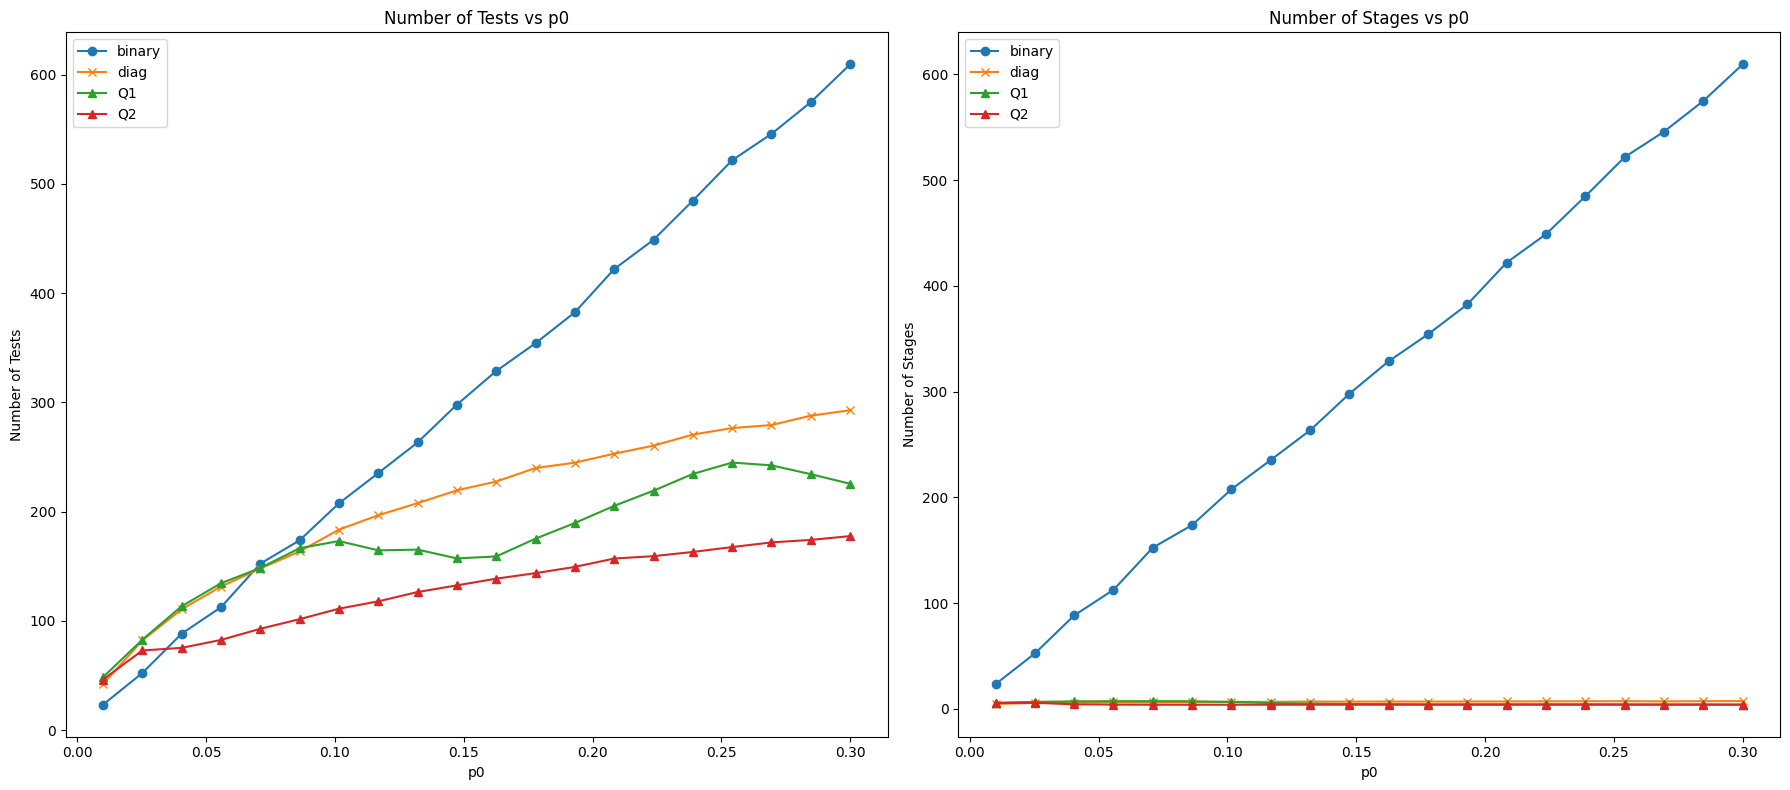

In [11]:
N = 256
M = 1
q0 = 0
q1 = 0
p1 = 0
time_steps = 0
num_sims = 100
binary = 'binary'
diag = 'diag'
testing1 = 'Q1'
testing2 = 'Q2'

p_values = np.linspace(.01, .3, 20)
plot_iid(N, M, q0, q1, p1, time_steps, num_sims, binary, diag, testing1, testing2, p_values)

ABOVE --> 
    N = 256
    M = 16
    q0 = .9
    q1 = .1

In [12]:
def plot_comms(N, M, q0, q1, p0, time_steps, num_sims, binary, diag, testingcomm1, testingcomm2, p_values):
    num_tests_binary = []
    num_stages_binary = []

    num_tests_diag = []
    num_stages_diag = []

    num_tests_comm1 = []
    num_stages_comm1 = []

    num_tests_comm2 = []
    num_stages_comm2 = []  
    for p1 in p_values:
        _, _, _, num_tests, num_stages = iter(N, M, q0, q1, p0, p1, time_steps, num_sims, binary, dataset='sbm')
        num_tests_binary.append(num_tests)
        num_stages_binary.append(num_stages)

    for p1 in p_values:
        _, _, _, num_tests, num_stages = iter(N, M, q0, q1, p0, p1, time_steps, num_sims, diag, dataset='sbm')
        num_tests_diag.append(num_tests)
        num_stages_diag.append(num_stages)

    # Community testing 1
    for p1 in p_values:
        _, _, _, num_tests, num_stages = iter(N, M, q0, q1, p0, p1, time_steps, num_sims, testingcomm1, dataset='sbm')
        num_tests_comm1.append(num_tests)
        num_stages_comm1.append(num_stages)     

    for p1 in p_values:
        _, _, _, num_tests, num_stages = iter(N, M, q0, q1, p0, p1, time_steps, num_sims, testingcomm2, dataset='sbm')
        num_tests_comm2.append(num_tests)
        num_stages_comm2.append(num_stages) 
    plt.figure(figsize=(18, 8))
    
    # Plot for number of tests
    plt.subplot(1, 2, 1)
    plt.plot(p_values, num_tests_binary, marker='o', label=binary)
    plt.plot(p_values, num_tests_diag, marker='x', label=diag)
    plt.plot(p_values, num_tests_comm1, marker='^', label=testingcomm1)
    plt.plot(p_values, num_tests_comm2, marker='o', label=testingcomm2)
    plt.title('Number of Tests vs p1')
    plt.xlabel('p1')
    plt.ylabel('Number of Tests')
    plt.legend()
    
    # Plot for number of stages
    plt.subplot(1, 2, 2)
    plt.plot(p_values, num_stages_binary, marker='o', label=binary)
    plt.plot(p_values, num_stages_diag, marker='x', label=diag)
    plt.plot(p_values, num_stages_comm1, marker='^', label=testingcomm1)
    plt.plot(p_values, num_stages_comm2, marker='o', label=testingcomm2)
    plt.title('Number of Stages vs p1')
    plt.xlabel('p1')
    plt.ylabel('Number of Stages')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

TOTAL TESTS:  13 

TOTAL TESTS:  23 

TOTAL TESTS:  19 

TOTAL TESTS:  16 

TOTAL TESTS:  16 

TOTAL TESTS:  18 

TOTAL TESTS:  18 

TOTAL TESTS:  23 

TOTAL TESTS:  16 

TOTAL TESTS:  16 

TOTAL TESTS:  23 

TOTAL TESTS:  23 

TOTAL TESTS:  25 

TOTAL TESTS:  20 

TOTAL TESTS:  21 

TOTAL TESTS:  23 

TOTAL TESTS:  20 

TOTAL TESTS:  16 

TOTAL TESTS:  13 

TOTAL TESTS:  23 

TOTAL TESTS:  16 

TOTAL TESTS:  23 

TOTAL TESTS:  20 

TOTAL TESTS:  16 

TOTAL TESTS:  25 

TOTAL TESTS:  20 

TOTAL TESTS:  18 

TOTAL TESTS:  23 

TOTAL TESTS:  23 

TOTAL TESTS:  21 

TOTAL TESTS:  25 

TOTAL TESTS:  23 

TOTAL TESTS:  21 

TOTAL TESTS:  13 

TOTAL TESTS:  23 

TOTAL TESTS:  21 

TOTAL TESTS:  23 

TOTAL TESTS:  21 

TOTAL TESTS:  18 

TOTAL TESTS:  21 

TOTAL TESTS:  25 

TOTAL TESTS:  23 

TOTAL TESTS:  21 

TOTAL TESTS:  25 

TOTAL TESTS:  19 

TOTAL TESTS:  23 

TOTAL TESTS:  19 

TOTAL TESTS:  25 

TOTAL TESTS:  21 

TOTAL TESTS:  23 

TOTAL TESTS:  21 

TOTAL TESTS:  20 

TOTAL TESTS:

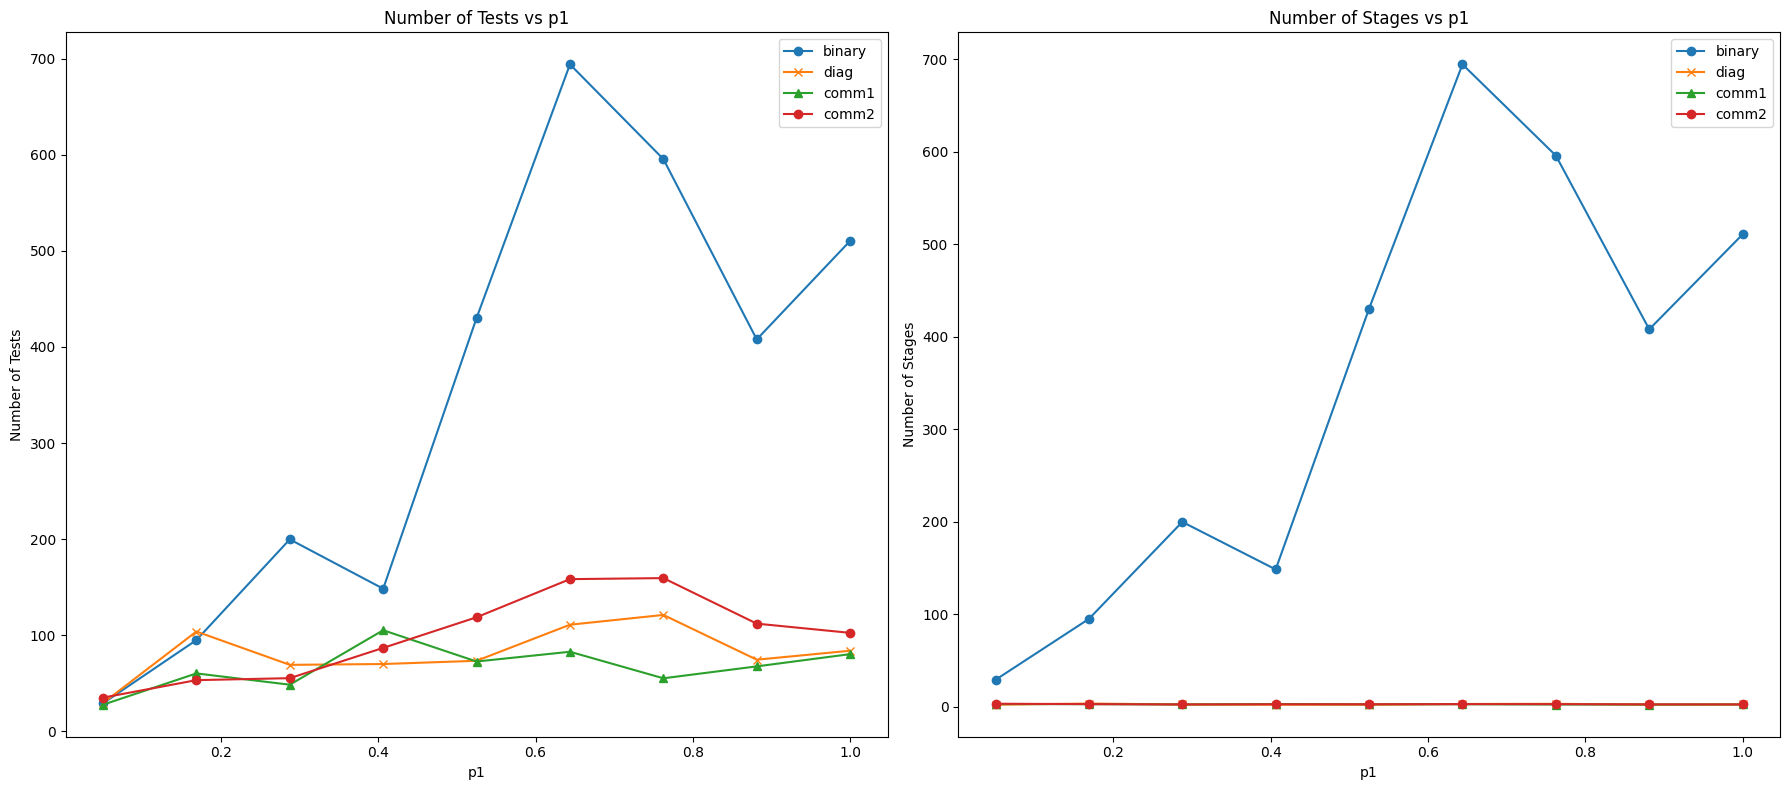

In [13]:
N = 256
M = 16
q0 = 0.9
q1 = 0.1
p0 = .001
time_steps = 2
num_sims = 40
binary = 'binary'
diag = 'diag'
testing1 = 'comm1'
testing2 = 'comm2'

p_values = np.linspace(.05, 1, 9)
plot_comms(N, M, q0, q1, p0, time_steps, num_sims, binary, diag, testing1, testing2, p_values)

ABOVE -->
    M = 16, q0 = .9, q1 = .1

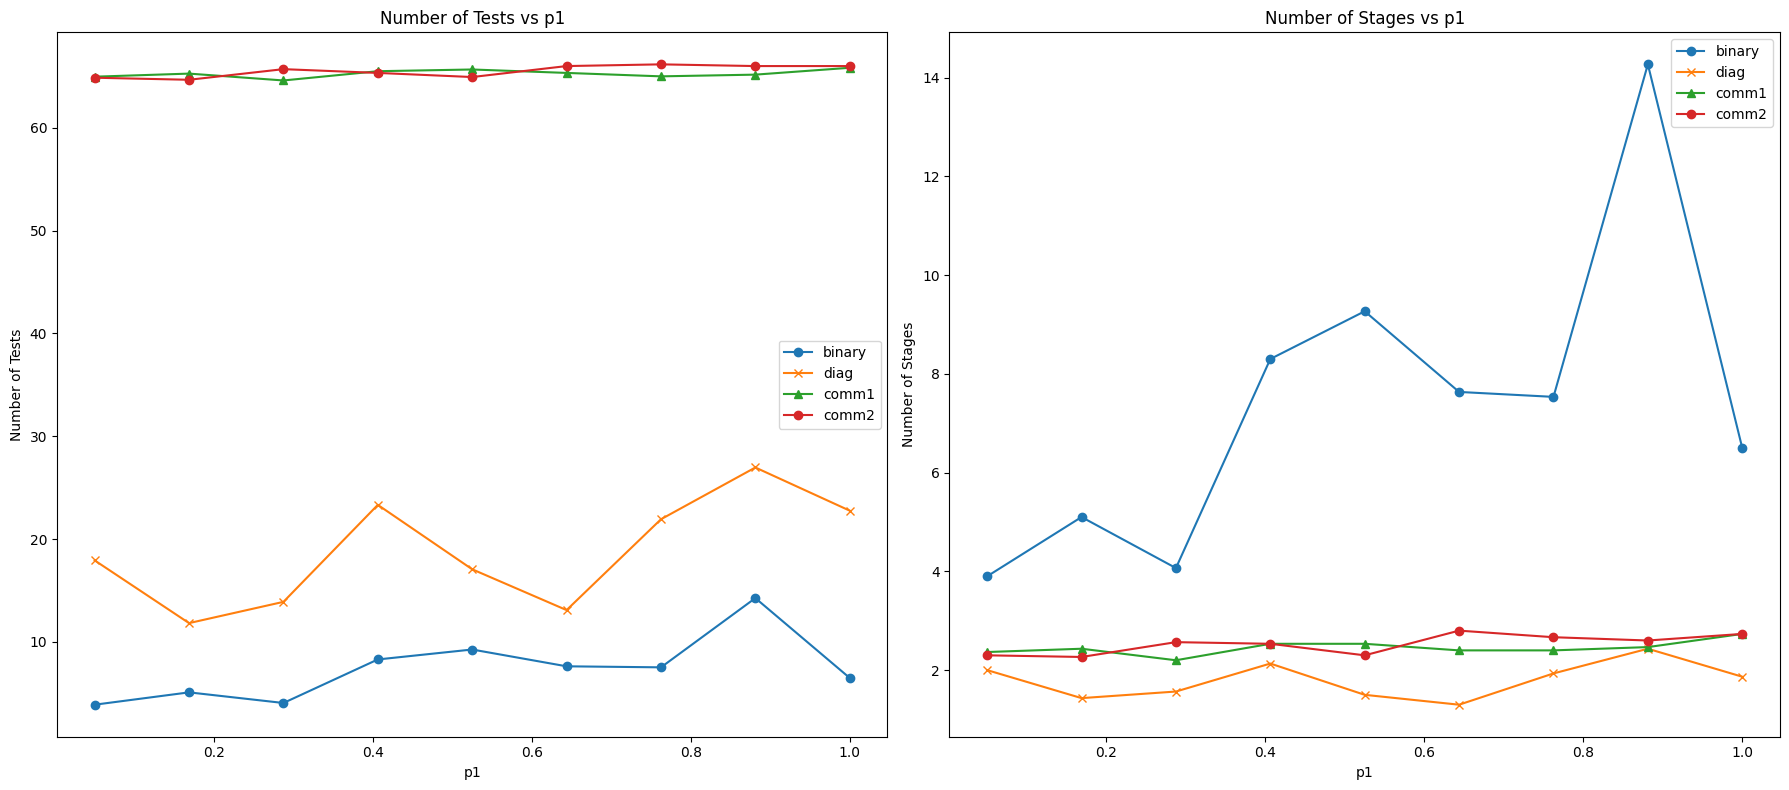

In [14]:
N = 256
M = 64
q0 = 1
q1 = 0
p0 = .001
time_steps = 2
num_sims = 30
binary = 'binary'
diag = 'diag'
testing1 = 'comm1'
testing2 = 'comm2'

p_values = np.linspace(.05, 1, 9)
plot_comms(N, M, q0, q1, p0, time_steps, num_sims, binary, diag, testing1, testing2, p_values)

ABOVE -->
    M = 16, q0 = 1, q1 = 0

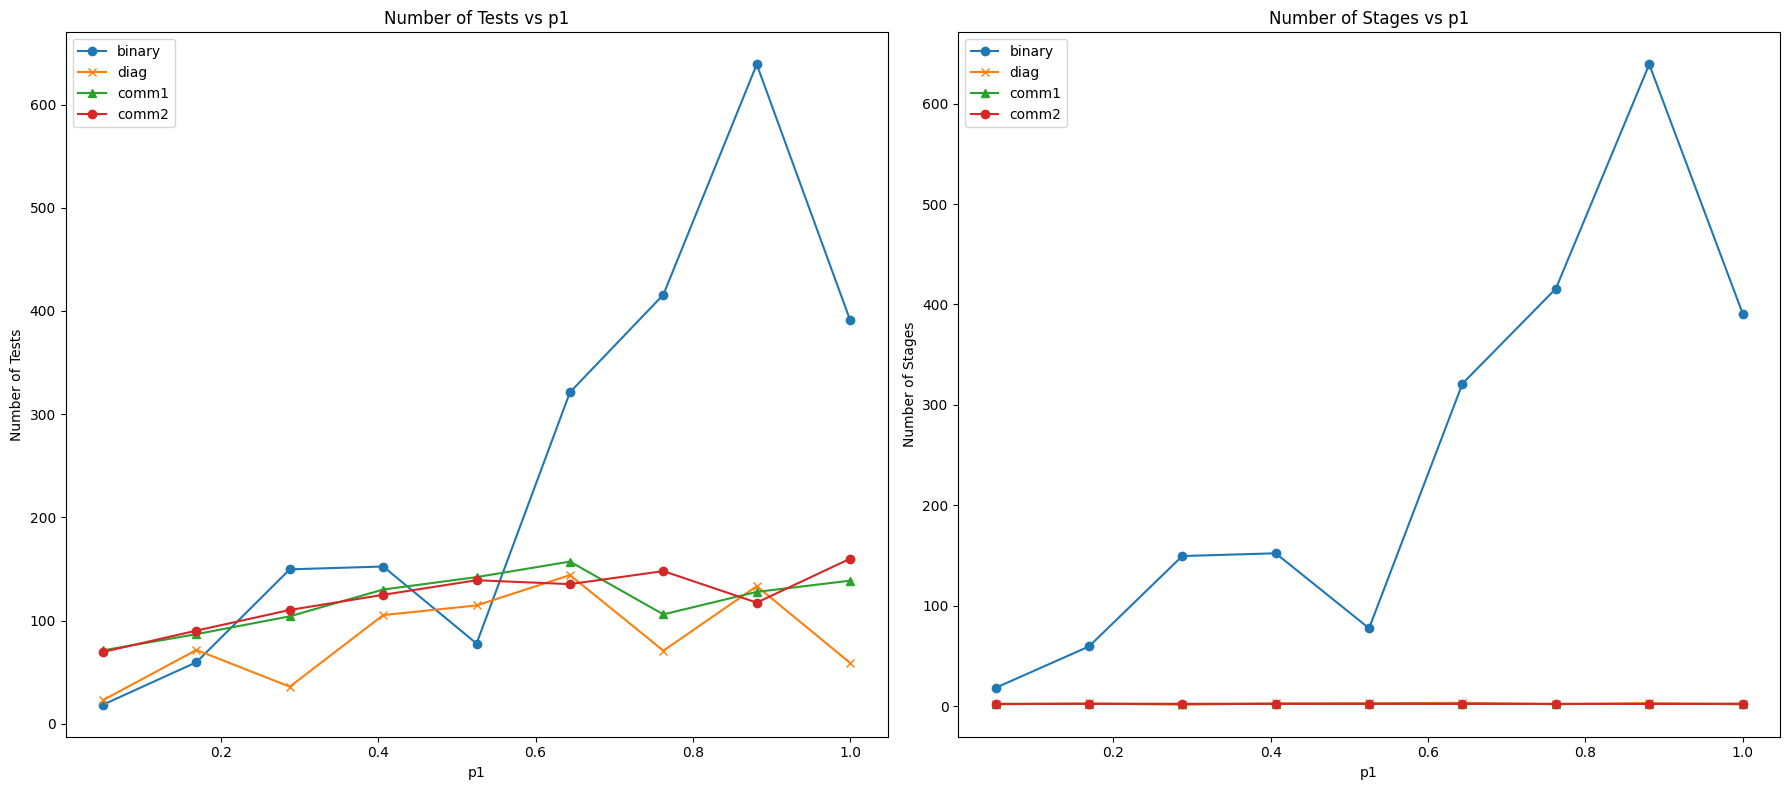

In [15]:
N = 256
M = 64
q0 = .9
q1 = .1
p0 = .001
time_steps = 2
num_sims = 30
binary = 'binary'
diag = 'diag'
testing1 = 'comm1'
testing2 = 'comm2'

p_values = np.linspace(.05, 1, 9)
plot_comms(N, M, q0, q1, p0, time_steps, num_sims, binary, diag, testing1, testing2, p_values)

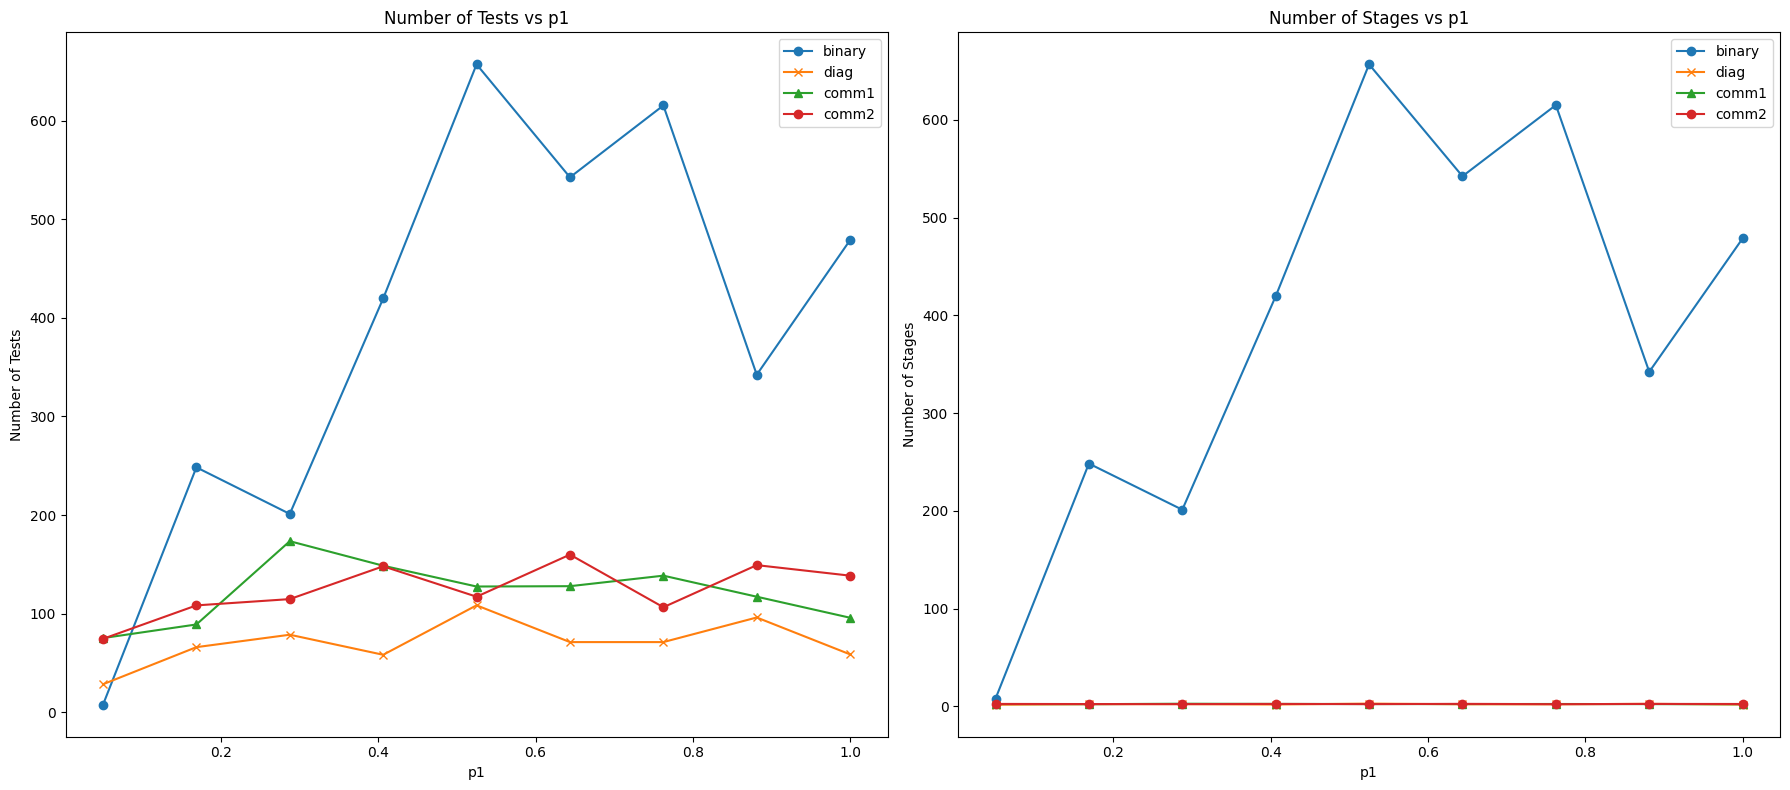

In [16]:
N = 256
M = 64
q0 = .5
q1 = .2
p0 = .001
time_steps = 2
num_sims = 30
binary = 'binary'
diag = 'diag'
testing1 = 'comm1'
testing2 = 'comm2'

p_values = np.linspace(.05, 1, 9)
plot_comms(N, M, q0, q1, p0, time_steps, num_sims, binary, diag, testing1, testing2, p_values)

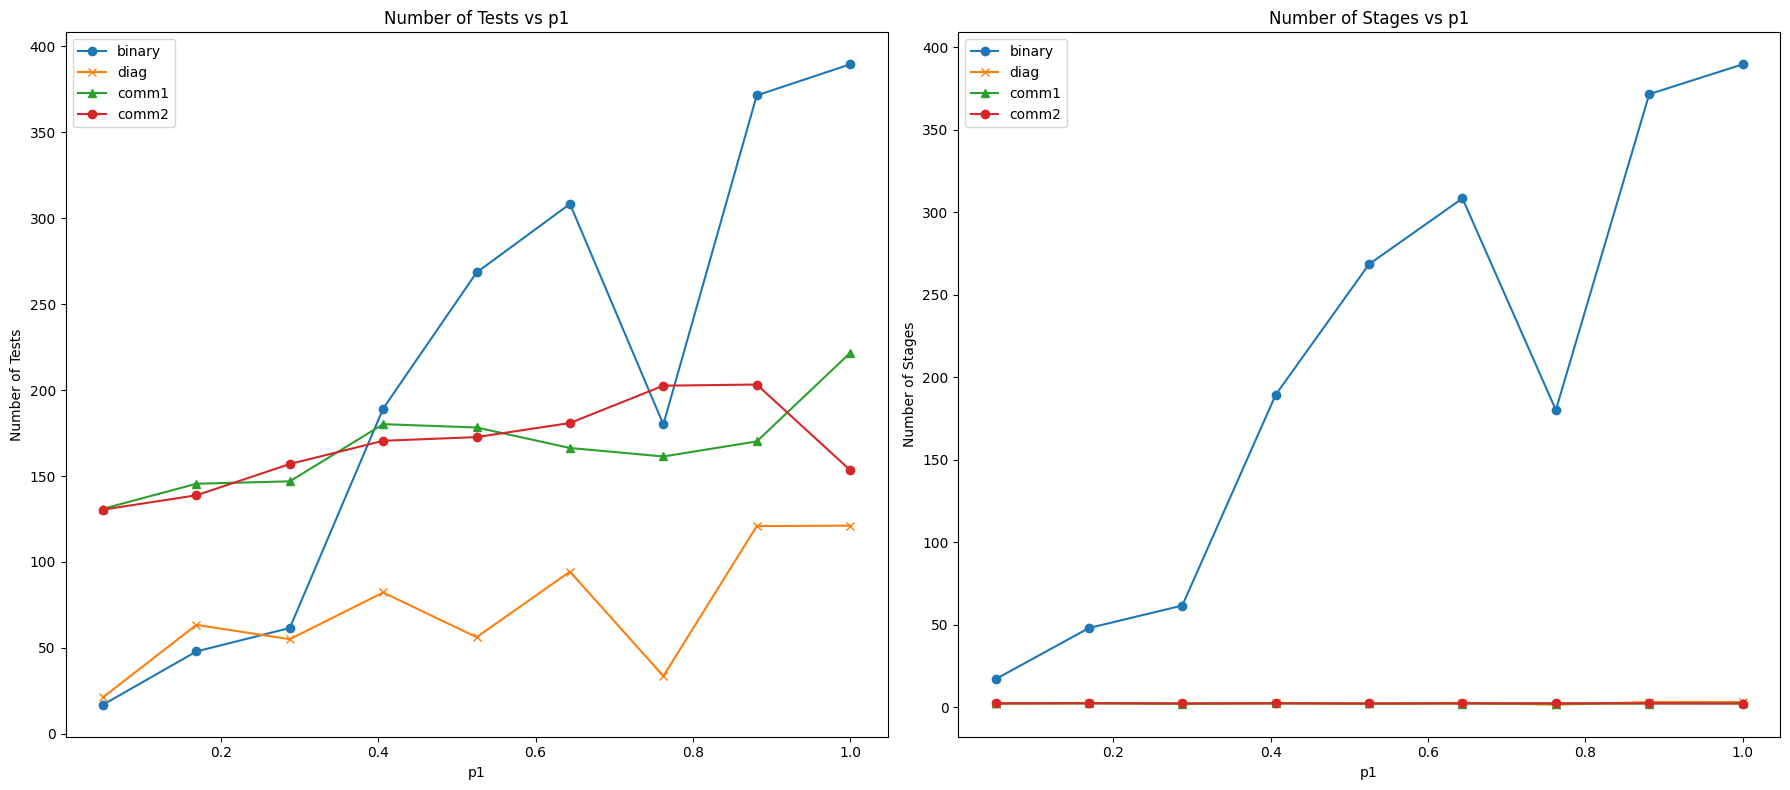

In [17]:
N = 256
M = 128
q0 = .9
q1 = .1
p0 = .001
time_steps = 2
num_sims = 30
binary = 'binary'
diag = 'diag'
testing1 = 'comm1'
testing2 = 'comm2'

p_values = np.linspace(.05, 1, 9)
plot_comms(N, M, q0, q1, p0, time_steps, num_sims, binary, diag, testing1, testing2, p_values)

Consider $N=256$, and $M=16,64,128$. Use SBM with $q0=1$ and $q1=0$ to generate contact networks (disconnected cliques). For the infection model, use $p_0 = 0.001$ and $p_1 = [0.01:1]$ and the number of infection steps as $2$ . 
Average over 100 SBM network realizations.

<div class="alert alert-warning">
<b>Task 2 </b> 
Provide plots for i.i.d. infection probability that ranges from $p=0.01$ to $p=0.3$, and $N=256$.
Compare the performance of tests $T_1$, $T_2$, and binary output tests. Do you observe a consistent performance? Can you explain your results? 
    
</div>

<div class="alert alert-warning">
<b>Task 3 </b>  
Provide plots that compare the performance of various testing techniques on the Stochastic Block Model (SBM) using the settings outlined in Table 2 and on real data. You may explore additional settings that could reveal significant insights for your custom algorithms. Interpret and explain the results you obtain. Your plots should include: (i) a plot demonstrating how the performance of different testing schemes varies as the family sizes change, (ii)a plot demonstrating how the performance of different testing schemes varies as the infection probability changes and (iii) a plot illustrating how infections concentrate within families in the SBM.
</div>

| N | M | q0, q1 | p0 | p1 |time steps  |
|---|---|--------|----|----|------------|
|256| 16| (0.9,0.1)  |0.001|[0.05:1]|2|
|   | 64|(1, 0)  | 0.001| [0.05:1]|2     |
|   | 64|(0.9, 0.1)  | 0.001| [0.05:1]|2     |
|   | 64|(0.5, 0.2)  | 0.001| [0.05:1]|2     |
|   | 128 |(0.9, 0.1)  | 0.001| [0.05:1]|2     |


In [ ]:
N = 256
M = 16
q0 = 0.5
q1 = 0.3

time_steps = 2
binary = 'your method'

In [ ]:
# the simulation 
t = 10
fraction_infected_ppl = np.zeros(t)
fraction_infected_clc = np.zeros(t)
fraction_infected_family = np.zeros(t)
num_tests = np.zeros((t,3))
num_stages = np.zeros((t,3))
p0 = 0.001
num_sims = 100
for j in range(1,t+1):
    p1 = j/t
    fraction_ppl[j-1], fraction_clc[j-1], fraction_plp_in_clc[j-1], num_tests[j-1], num_stages[j-1]= iter(N,M,q0,q1,p0,p1,time_steps,num_sims,binary,dataset='sbm')  
       

In [ ]:
p1s = np.arange(1,t+1)/t

In [ ]:
plt.figure(figsize=(6, 4), dpi=300)
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'sans-serif',
    'font.sans-serif': 'Arial',
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})
markers = ['.', ',','o','v','^','<','>']
   
plt.plot(p1s,num_tests[:,i],label='binary splitting',marker=markers[i])
#########your code here###########

plt.xlabel('Transmission probability: p1',fontsize=14)
plt.ylabel('Expected number of tests',fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.legend(frameon=False, loc='best')
plt.tight_layout()
fig_name = 'RES_N'+str(N)+'_M'+str(M)+'SIM'+str(num_sims)+'step_'+str(time_steps)+'q0'+str(q0)+'q1'+str(q1)+'p0'+str(p0)+binary+'GT.pdf'
plt.savefig(fig_name, format='pdf', bbox_inches='tight')

In [ ]:
plt.plot(p1s,fraction_ppl,label='Fraction of infected people')
plt.plot(p1s,fraction_clc,label='Fraction of infected communities')
plt.plot(p1s,fraction_plp_in_clc,label='Fraction of infected people in each community')
plt.xlabel('Transmission probability: p1',fontsize=14)
plt.ylabel('Infection stats',fontsize=14)
plt.legend()
plt.savefig('RES_N'+str(N)+'_M'+str(M)+'SIM'+str(num_sims)+'step_'+str(time_steps)+'q0'+str(q0)+'q1'+str(q1)+'p0'+str(p0)+binary+'stats.pdf')